In [5]:
import pandas as pd
from rectools import Columns
from rectools.dataset import Dataset
from rectools.model_selection.random_split import RandomSplitter

df = pd.read_csv('train (2).csv')

df_ratings = df[["userId", "id"]].copy()
df_ratings["weight"] = 1
df_ratings["time"] = "2001-09-11 4:20:00" #ОЧЕНЬ ВАЖНО НЕ МЕНЯТЬ ПОСЛЕ ЭТОГО МЫ ВСЕ АРАБОФОБЫ БЛЯТЬ
df_ratings = df_ratings.rename(columns={"userId": Columns.User, "id": Columns.Item, "weight": Columns.Weight, "time": Columns.Datetime})

df_songs_features = df[["id", "artistId"]].copy()
df_songs_features = df_songs_features.rename(columns={"id": Columns.Item, "artistId": "value"})
df_songs_features["feature"] = "artistId"
df_songs_features = df_songs_features.drop_duplicates(subset=["item_id"])

dataset = Dataset.construct(interactions_df=df_ratings, item_features_df=df_songs_features, cat_item_features=["artistId"], make_dense_item_features=False)

In [6]:
submission = pd.read_csv("3.1 A.csv")
users_for_tests = submission.userId.values

In [7]:
from rectools.models import PopularModel
from rectools.metrics import MAP
# Fit model and generate recommendations for all users

model = PopularModel()
model.fit(dataset)
recos = model.recommend(
    users=df_ratings.user_id.unique(),
    dataset=dataset,
    k=3,
    filter_viewed=True,
)

submission_for_tests = submission.melt(id_vars=["userId"], value_vars=['recommended_id_1', 'recommended_id_2', 'recommended_id_3'], var_name="ХуйЗнаетУдалюВсёРавно", value_name=Columns.Item)
submission_for_tests = submission_for_tests[['userId', Columns.Item]].sort_values(by='userId').reset_index(drop=True)
submission_for_tests = submission_for_tests.rename(columns={"userId":Columns.User})

MAP(k=3).calc(recos, submission_for_tests)

0.004697771240754454

In [8]:
lol = set(df_ratings[Columns.User].values)
kek = set(submission_for_tests[Columns.User].values)

2*len(lol & kek)/ (len(lol) + len(kek))

0.4276684995910641

In [42]:
MAP(k=3, divide_by_k=True).calc(recos, submission_for_tests) 

0.004697771240754454

In [43]:
from rectools.models.random import RandomModel

model = RandomModel()
model.fit(dataset)
recos = model.recommend(
    users=df_ratings.user_id.unique(),
    dataset=dataset, 
    k=3,
    filter_viewed=True
)

MAP(k=3).calc(recos, submission_for_tests)

9.999817146200755e-07

In [44]:
from rectools.models import LightFMWrapperModel
from lightfm import LightFM

model = LightFMWrapperModel(
        # внутри модели указываем параметр no_components
        # это размезность эмбеддингов, которые выучит модель
        model=LightFM(no_components = 30)
        )

model.fit(dataset)
recos = model.recommend(
    users=users_for_tests,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)

In [45]:
MAP(k=3).calc(recos, submission_for_tests)

0.005198190661656472

In [9]:
hot_users = set(submission_for_tests[Columns.User].values) & set(df_ratings[Columns.User].values)
cold_users = set(submission_for_tests[Columns.User].values) - set(df_ratings[Columns.User].values)


In [47]:
# Давайте для холодных просто поплуярные пикать, а для горячих с помощью LightFM

lightfm_recos = model.recommend(
    users=hot_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)

popular_model = PopularModel()
popular_model.fit(dataset=dataset)
popular_recos = popular_model.recommend(
    users=cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)

In [48]:
concat_recos = pd.concat([popular_recos, lightfm_recos])

In [49]:
MAP(k=3).calc(concat_recos, submission_for_tests)

0.0054249008018139085

<Axes: xlabel='id', ylabel='Count'>

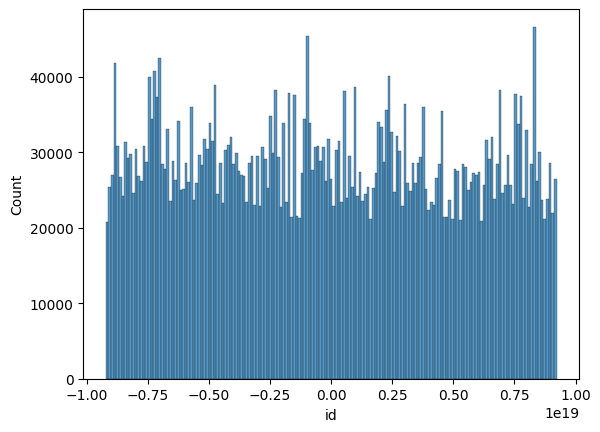

In [50]:
import seaborn as sns
sns.histplot(data=df, x="id")

In [22]:
# kNN with BM25
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import BM25Recommender




popular_model = PopularModel()
popular_model.fit(dataset=dataset)
popular_recos = popular_model.recommend(
    users=cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)


mapka_jopa = []
for K in range(1, 101, 2):
    bm25knn_model = ImplicitItemKNNWrapperModel(
    model=BM25Recommender(K=K)
    )

    bm25knn_model.fit(dataset)
    bm25knn_recos = bm25knn_model.recommend(
        users=hot_users,
        dataset=dataset,
        k=3,
        filter_viewed=True
    )
    concat_recos = pd.concat([popular_recos, bm25knn_recos])

    metric = MAP(k=3).calc(concat_recos, submission_for_tests)
    mapka_jopa.append(metric)
    print(f"K: {K}  MAP@k: {metric} Score {metric*120}")

K: 1  MAP@k: 0.0012284061091454327 Score 0.14740873309745192
K: 3  MAP@k: 0.007325008914122715 Score 0.8790010696947258
K: 5  MAP@k: 0.008044995748649164 Score 0.9653994898378997
K: 7  MAP@k: 0.00835641862548799 Score 1.0027702350585588
K: 9  MAP@k: 0.008526986935096046 Score 1.0232384322115256
K: 11  MAP@k: 0.008653984612852795 Score 1.0384781535423353
K: 13  MAP@k: 0.0087339831500224 Score 1.0480779780026879
K: 15  MAP@k: 0.008800410506779302 Score 1.0560492608135164
K: 17  MAP@k: 0.008850552447040966 Score 1.062066293644916
K: 19  MAP@k: 0.008907551404774313 Score 1.0689061685729175
K: 21  MAP@k: 0.008959550453934555 Score 1.0751460544721465
K: 23  MAP@k: 0.008984978560392036 Score 1.0781974272470443
K: 25  MAP@k: 0.00900683530358302 Score 1.0808202364299624
K: 27  MAP@k: 0.009028406337712682 Score 1.0834087605255218


KeyboardInterrupt: 

In [24]:
# Cosine with kNN

from implicit.nearest_neighbours import CosineRecommender




popular_model = PopularModel()
popular_model.fit(dataset=dataset)
popular_recos = popular_model.recommend(
    users=cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)



mapka_jopa = []
for K in range(1, 101, 2):
    cosineknn_model = ImplicitItemKNNWrapperModel(
    model=CosineRecommender(K=K)
    )

    cosineknn_model.fit(dataset)
    cosineknn_recos = cosineknn_model.recommend(
        users=hot_users,
        dataset=dataset,
        k=3,
        filter_viewed=True
    )
    concat_recos = pd.concat([popular_recos, cosineknn_recos])

    metric=MAP(k=3).calc(concat_recos, submission_for_tests)
    mapka_jopa.append(metric)
    print(f"K: {K}  MAP@k: {metric} Score {metric*120}")

K: 1  MAP@k: 0.0012284061091454327 Score 0.14740873309745192
K: 3  MAP@k: 0.012977048419686036 Score 1.5572458103623243
K: 5  MAP@k: 0.014130170191173644 Score 1.6956204229408374
K: 7  MAP@k: 0.01442945043290637 Score 1.7315340519487645
K: 9  MAP@k: 0.014523734423141976 Score 1.7428481307770372
K: 11  MAP@k: 0.014604304378434223 Score 1.752516525412107
K: 13  MAP@k: 0.014681302970459964 Score 1.7617563564551957
K: 15  MAP@k: 0.014734873419457471 Score 1.7681848103348965
K: 17  MAP@k: 0.014779444033023394 Score 1.7735332839628073
K: 19  MAP@k: 0.014799729376377118 Score 1.7759675251652542
K: 21  MAP@k: 0.014852299843659999 Score 1.7822759812392
K: 23  MAP@k: 0.014909441655924007 Score 1.7891329987108808
K: 25  MAP@k: 0.014994297247136048 Score 1.7993156696563257
K: 27  MAP@k: 0.0150505819322161 Score 1.806069831865932
K: 29  MAP@k: 0.015067010203241993 Score 1.8080412243890391
K: 31  MAP@k: 0.015099295327171159 Score 1.811915439260539
K: 33  MAP@k: 0.015144723067921034 Score 1.817366768

KeyboardInterrupt: 

In [26]:
# Хз зачем тут TFIDF, но пусть будет
# TFIDR with kNN

from implicit.nearest_neighbours import TFIDFRecommender



popular_model = PopularModel()
popular_model.fit(dataset=dataset)
popular_recos = popular_model.recommend(
    users=cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)

mapka_jopa = []
for K in range(1, 101, 2):
    tfidfknn_model = ImplicitItemKNNWrapperModel(
    model=TFIDFRecommender(K=K)
    )

    tfidfknn_model.fit(dataset)
    tfidfknn_recos = tfidfknn_model.recommend(
        users=hot_users,
        dataset=dataset,
        k=3,
        filter_viewed=True
    )
    concat_recos = pd.concat([popular_recos, tfidfknn_recos])

    metric=MAP(k=3).calc(concat_recos, submission_for_tests)
    mapka_jopa.append(metric)
    print(f"K: {K}  MAP@k: {metric} Score {metric*120}")

K: 1  MAP@k: 0.0012284061091454327 Score 0.14740873309745192
K: 3  MAP@k: 0.013101474715890914 Score 1.5721769659069098
K: 5  MAP@k: 0.014065028525192676 Score 1.6878034230231211
K: 7  MAP@k: 0.014473878191941635 Score 1.7368653830329963
K: 9  MAP@k: 0.014561448019236216 Score 1.7473737623083458
K: 11  MAP@k: 0.014654017755103903 Score 1.7584821306124683
K: 13  MAP@k: 0.014747730327216872 Score 1.7697276392660246
K: 15  MAP@k: 0.014807872084624734 Score 1.7769446501549682
K: 17  MAP@k: 0.014846299953372282 Score 1.781555994404674
K: 19  MAP@k: 0.014882727858690586 Score 1.7859273430428704
K: 21  MAP@k: 0.014941726779853162 Score 1.7930072135823794
K: 23  MAP@k: 0.015028439479963797 Score 1.8034127375956557
K: 25  MAP@k: 0.015051296204869396 Score 1.8061555445843276
K: 27  MAP@k: 0.015112723653053198 Score 1.8135268383663838
K: 29  MAP@k: 0.015132723287345605 Score 1.8159267944814725
K: 31  MAP@k: 0.015173722537645028 Score 1.8208467045174033


KeyboardInterrupt: 

In [25]:
# Хз зачем тут TFIDR, но пусть будет
# TFIDR with kNN

from implicit.nearest_neighbours import ItemItemRecommender



popular_model = PopularModel()
popular_model.fit(dataset=dataset)
popular_recos = popular_model.recommend(
    users=cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True
)

mapka_jopa = []
for K in range(1, 101, 2):
    itemitemknn_model = ImplicitItemKNNWrapperModel(
    model=ItemItemRecommender(K=K)
    )

    itemitemknn_model.fit(dataset)
    itemitemknn_recos = itemitemknn_model.recommend(
        users=hot_users,
        dataset=dataset,
        k=3,
        filter_viewed=True
    )
    concat_recos = pd.concat([popular_recos, itemitemknn_recos])

    metric=MAP(k=3).calc(concat_recos, submission_for_tests)
    mapka_jopa.append(metric)
    print(f"K: {K}  MAP@k: {metric} Score {metric*120}")

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'